# PS S6E2 — EDA Notebook

Purpose:
1) Understand feature distributions + potential outliers
2) Check train vs test distribution shift
3) Identify which features relate to target (Heart Disease Presence)
4) Produce a short written EDA summary in /reports


imports + paths

In [1]:
from __future__ import annotations

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

ROOT = Path.cwd().resolve().parents[0]   # notebooks/ -> repo root
DATA_DIR = ROOT / "data" / "raw"
REPORTS_DIR = ROOT / "reports"
FIG_DIR = REPORTS_DIR / "figures"
REPORTS_DIR.mkdir(parents=True, exist_ok=True)
FIG_DIR.mkdir(parents=True, exist_ok=True)

TRAIN_PATH = DATA_DIR / "train.csv"
TEST_PATH  = DATA_DIR / "test.csv"
SUB_PATH   = DATA_DIR / "sample_submission.csv"


load + detect id/target

In [2]:
train = pd.read_csv(TRAIN_PATH)
test  = pd.read_csv(TEST_PATH)
sub   = pd.read_csv(SUB_PATH)

id_col = sub.columns[0]
target_col = sub.columns[1]

print("id_col:", id_col, "| target_col:", target_col)
print("train:", train.shape, "| test:", test.shape)
train.head()


id_col: id | target_col: Heart Disease
train: (630000, 15) | test: (270000, 14)


,id,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Heart Disease
0,0,58,1,4,152,239,0,0,158,1,3.6,2,2,7,Presence
1,1,52,1,1,125,325,0,2,171,0,0.0,1,0,3,Absence
2,2,56,0,2,160,188,0,2,151,0,0.0,1,0,3,Absence
3,3,44,0,3,134,229,0,2,150,0,1.0,2,0,3,Absence
4,4,58,1,4,140,234,0,2,125,1,3.8,2,3,3,Presence


(target encoding + split)

In [3]:
y = (train[target_col] == "Presence").astype(int)
X = train.drop(columns=[target_col])
X_test = test.copy()

print("Positive rate (Presence):", y.mean())
print("X shape:", X.shape, "X_test shape:", X_test.shape)

# sanity: train/test feature alignment
assert list(X.columns) == list(X_test.columns)


Positive rate (Presence): 0.44833968253968254
X shape: (630000, 14) X_test shape: (270000, 14)


compute unique counts and define cat/num columns

In [4]:
# Count how many unique values each feature has
nunique = X.nunique(dropna=False).sort_values()

print("Unique values per column (sorted):")
display(nunique)

# Heuristic: if a column has <= 10 unique values, treat it as categorical-like
cat_cols = nunique[nunique <= 10].index.tolist()
num_cols = [c for c in X.columns if c not in cat_cols]

print("\nCategorical-like columns (<=10 unique):", cat_cols)
print("Numeric-like columns:", num_cols)


Unique values per column (sorted):


Sex                             2
FBS over 120                    2
Exercise angina                 2
EKG results                     3
Slope of ST                     3
Thallium                        3
Number of vessels fluro         4
Chest pain type                 4
Age                            42
ST depression                  66
BP                             66
Max HR                         93
Cholesterol                   150
id                         630000
dtype: int64


Categorical-like columns (<=10 unique): ['Sex', 'FBS over 120', 'Exercise angina', 'EKG results', 'Slope of ST', 'Thallium', 'Number of vessels fluro', 'Chest pain type']
Numeric-like columns: ['id', 'Age', 'BP', 'Cholesterol', 'Max HR', 'ST depression']


remove id + describe
Now we want to answer:

Are there impossible values? (negative BP?)

Are there weird ranges/outliers? (Cholesterol extremely high?)

Are train and test ranges similar? (early hint of shift)

In [5]:
# Remove id from features for analysis/modeling
feature_cols = [c for c in X.columns if c != id_col]
cat_cols = [c for c in cat_cols if c != id_col]
num_cols = [c for c in num_cols if c != id_col]

print("feature_cols:", feature_cols)
print("cat_cols:", cat_cols)
print("num_cols:", num_cols)

# Summary stats for numeric columns
desc_train = X[feature_cols].describe().T
desc_test  = X_test[feature_cols].describe().T

display(desc_train.loc[num_cols])
display(desc_test.loc[num_cols])


feature_cols: ['Age', 'Sex', 'Chest pain type', 'BP', 'Cholesterol', 'FBS over 120', 'EKG results', 'Max HR', 'Exercise angina', 'ST depression', 'Slope of ST', 'Number of vessels fluro', 'Thallium']
cat_cols: ['Sex', 'FBS over 120', 'Exercise angina', 'EKG results', 'Slope of ST', 'Thallium', 'Number of vessels fluro', 'Chest pain type']
num_cols: ['Age', 'BP', 'Cholesterol', 'Max HR', 'ST depression']


,count,mean,std,min,25%,50%,75%,max
Age,630000.0,54.136706,8.256301,29.0,48.0,54.0,60.0,77.0
BP,630000.0,130.497433,14.975802,94.0,120.0,130.0,140.0,200.0
Cholesterol,630000.0,245.011814,33.681581,126.0,223.0,243.0,269.0,564.0
Max HR,630000.0,152.816763,19.112927,71.0,142.0,157.0,166.0,202.0
ST depression,630000.0,0.716028,0.948472,0.0,0.0,0.1,1.4,6.2


,count,mean,std,min,25%,50%,75%,max
Age,270000.0,54.159870,8.255471,29.0,48.0,54.0,60.0,77.0
BP,270000.0,130.555089,15.007908,94.0,120.0,130.0,140.0,200.0
Cholesterol,270000.0,245.045270,33.695458,126.0,223.0,243.0,269.0,564.0
Max HR,270000.0,152.783756,19.153454,71.0,142.0,157.0,166.0,202.0
ST depression,270000.0,0.718082,0.947417,0.0,0.0,0.1,1.4,6.2


“Which features actually predict the target?”
We’ll do two quick analyses:

1, numeric features: mean/median by class + effect size

2, categorical features: Presence rate by category

numeric feature summary by target

In [6]:
# Combine X + target for EDA
eda = X[feature_cols].copy()
eda[target_col] = train[target_col]
eda["y"] = y  # 0/1

# Numeric: compare mean by class
rows = []
for c in num_cols:
    mean_abs = eda.loc[eda["y"] == 0, c].mean()
    mean_pre = eda.loc[eda["y"] == 1, c].mean()
    diff = mean_pre - mean_abs
    rows.append([c, mean_abs, mean_pre, diff])

num_by_class = pd.DataFrame(rows, columns=["feature", "mean_absence", "mean_presence", "presence_minus_absence"])
num_by_class.sort_values("presence_minus_absence", ascending=False)


,feature,mean_absence,mean_presence,presence_minus_absence
2,Cholesterol,242.499102,248.103585,5.604483
0,Age,52.558093,56.079114,3.521021
4,ST depression,0.347808,1.169104,0.821296
1,BP,130.567381,130.411366,-0.156015
3,Max HR,160.415105,143.467372,-16.947733


quick plots for numeric features (sampled)

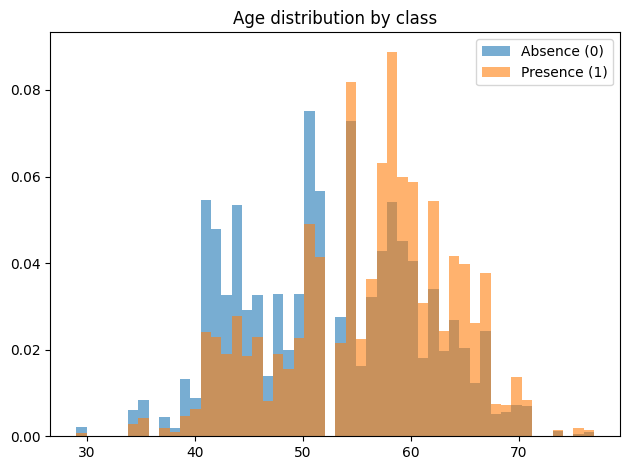

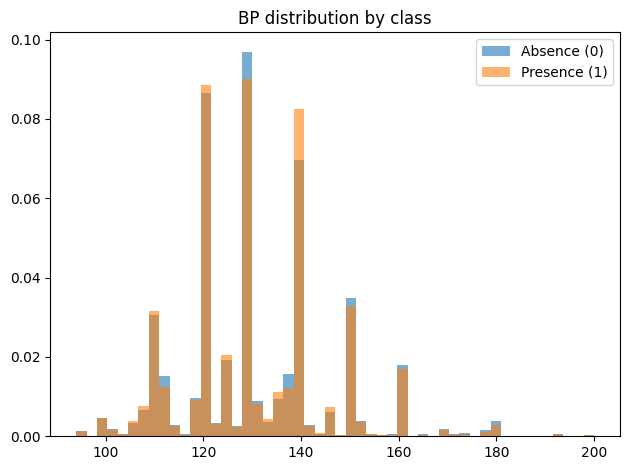

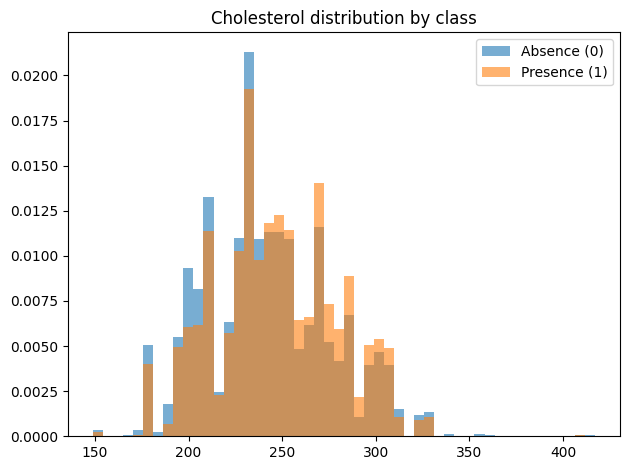

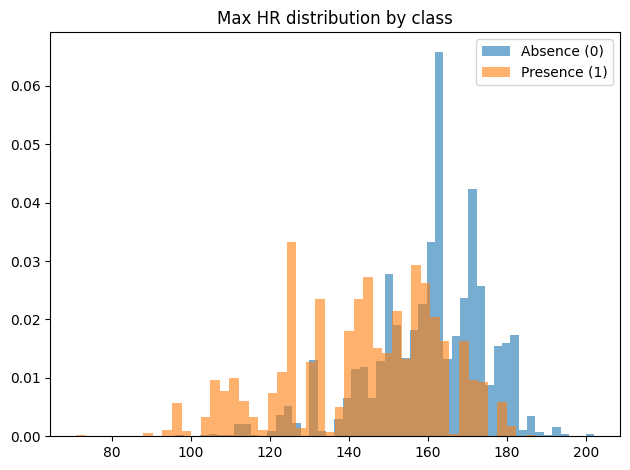

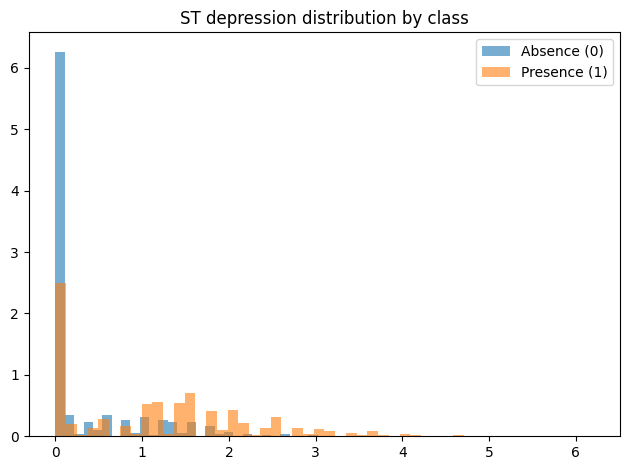

In [8]:
SAMPLE_N = 50_000
eda_s = eda.sample(SAMPLE_N, random_state=42)

def plot_hist_by_class(df: pd.DataFrame, col: str, bins: int = 50):
    a = df[df["y"] == 0][col].dropna()
    p = df[df["y"] == 1][col].dropna()

    plt.figure()
    plt.hist(a, bins=bins, alpha=0.6, density=True, label="Absence (0)")
    plt.hist(p, bins=bins, alpha=0.6, density=True, label="Presence (1)")
    plt.title(f"{col} distribution by class")
    plt.legend()
    plt.tight_layout()

for c in num_cols:
    plot_hist_by_class(eda_s, c, bins=50)
    plt.savefig(FIG_DIR / f"hist_by_class_{c.replace(' ', '_')}.png", dpi=150)
    plt.show()


categorical features

Now we do the same idea but for your categorical-like columns:

✅ For each category value, compute:

count

presence rate

(optional) plot it

This is super useful because:

It tells you which categories are “high risk”

It often becomes your strongest feature set

It helps decide how to encode for Logistic Regression (one-hot vs ordinal)

presence rate by category (table)

In [9]:
# Categorical: presence rate by category value
cat_tables = {}

for c in cat_cols:
    tmp = pd.DataFrame({
        c: X[c],
        "y": y
    })
    tbl = tmp.groupby(c)["y"].agg(["count", "mean"]).rename(columns={"mean": "presence_rate"})
    tbl = tbl.sort_index()
    cat_tables[c] = tbl
    print(f"\n=== {c} ===")
    display(tbl)



=== Sex ===


,count,presence_rate
Sex,,
0,179717,0.178764
1,450283,0.555933



=== FBS over 120 ===


,count,presence_rate
FBS over 120,,
0,579608,0.443417
1,50392,0.504961



=== Exercise angina ===


,count,presence_rate
Exercise angina,,
0,457553,0.313433
1,172447,0.806288



=== EKG results ===


,count,presence_rate
EKG results,,
0,320116,0.341498
1,1322,0.360061
2,308562,0.559560



=== Slope of ST ===


,count,presence_rate
Slope of ST,,
1,358293,0.262257
2,256215,0.692067
3,15492,0.721082



=== Thallium ===


,count,presence_rate
Thallium,,
3,372286,0.198049
6,10966,0.686394
7,246748,0.815391



=== Number of vessels fluro ===


,count,presence_rate
Number of vessels fluro,,
0,445862,0.303132
1,106978,0.729346
2,54303,0.897078
3,22857,0.899549



=== Chest pain type ===


,count,presence_rate
Chest pain type,,
1,28602,0.108069
2,74941,0.162181
3,197278,0.190665
4,329179,0.697478


bar plot for presence rate (visual)

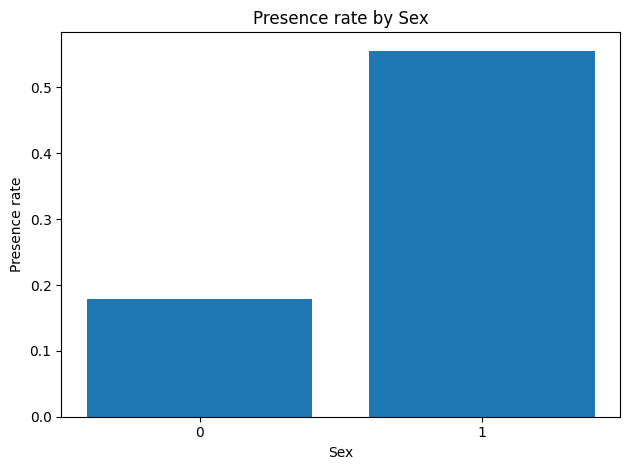

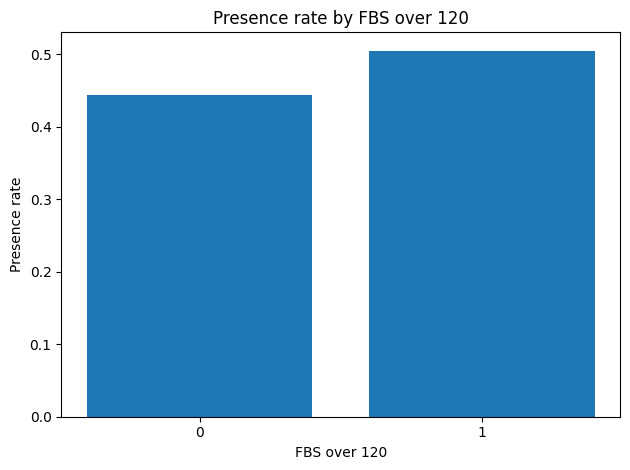

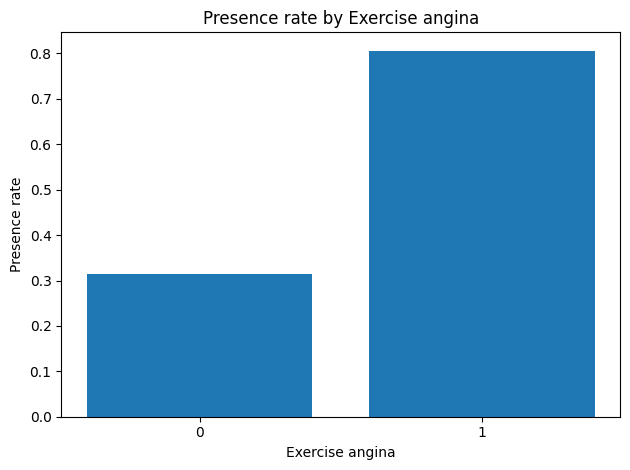

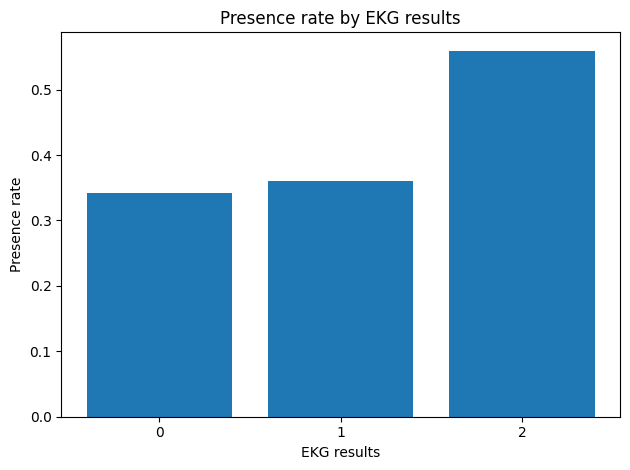

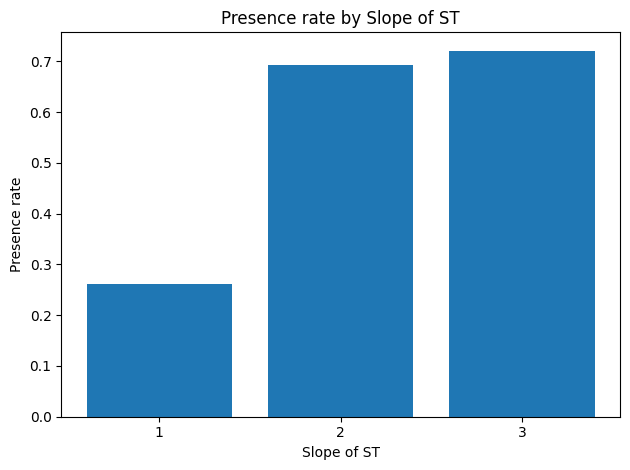

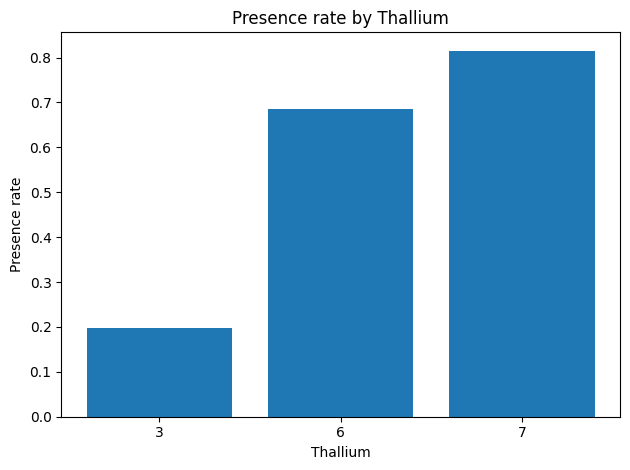

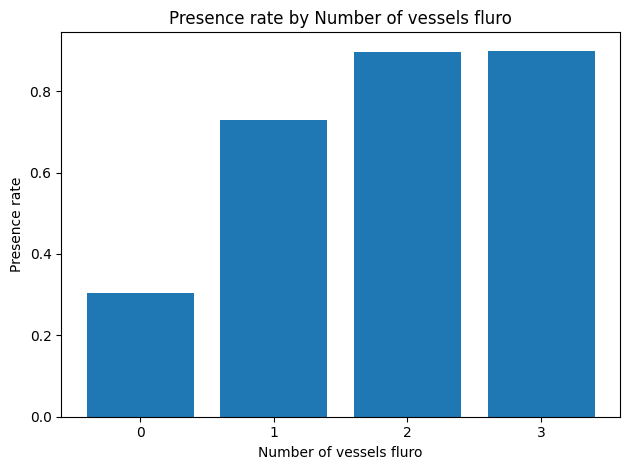

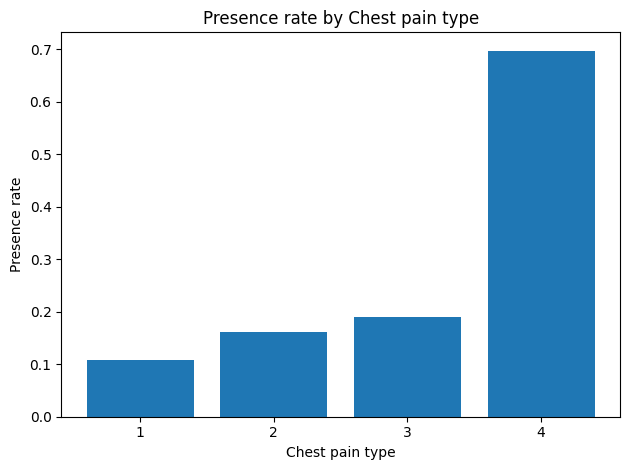

In [10]:
def plot_presence_rate(tbl: pd.DataFrame, col_name: str):
    plt.figure()
    plt.bar(tbl.index.astype(str), tbl["presence_rate"])
    plt.title(f"Presence rate by {col_name}")
    plt.xlabel(col_name)
    plt.ylabel("Presence rate")
    plt.tight_layout()

for c, tbl in cat_tables.items():
    plot_presence_rate(tbl, c)
    plt.savefig(FIG_DIR / f"presence_rate_{c.replace(' ', '_')}.png", dpi=150)
    plt.show()


check categorical shift train vs test

In [11]:
shift_cat_rows = []
for c in cat_cols:
    tr = X[c].value_counts(normalize=True).sort_index()
    te = X_test[c].value_counts(normalize=True).sort_index()
    idx = sorted(set(tr.index).union(set(te.index)))
    tr = tr.reindex(idx, fill_value=0)
    te = te.reindex(idx, fill_value=0)
    l1 = float((tr - te).abs().sum())  # simple shift metric
    shift_cat_rows.append([c, l1])

cat_shift = pd.DataFrame(shift_cat_rows, columns=["feature", "L1_shift"]).sort_values("L1_shift", ascending=False)
cat_shift


,feature,L1_shift
4,Slope of ST,0.006179
6,Number of vessels fluro,0.004420
7,Chest pain type,0.004180
3,EKG results,0.003236
0,Sex,0.003160
2,Exercise angina,0.001860
5,Thallium,0.000621
1,FBS over 120,0.000129


Lift table (which categories are most risky / safest)

In [12]:
base = float(y.mean())

lift_rows = []
for c, tbl in cat_tables.items():
    for level, row in tbl.iterrows():
        lift_rows.append([c, level, int(row["count"]), float(row["presence_rate"]), float(row["presence_rate"] - base)])

lift = pd.DataFrame(lift_rows, columns=["feature", "level", "count", "presence_rate", "lift_vs_base"])
lift_sorted = lift.sort_values("lift_vs_base", ascending=False)

print("Top high-risk categories (largest positive lift):")
display(lift_sorted.head(12))

print("Top low-risk categories (largest negative lift):")
display(lift_sorted.tail(12).sort_values("lift_vs_base"))


Top high-risk categories (largest positive lift):


,feature,level,count,presence_rate,lift_vs_base
18,Number of vessels fluro,3,22857,0.899549,0.451210
17,Number of vessels fluro,2,54303,0.897078,0.448738
14,Thallium,7,246748,0.815391,0.367051
5,Exercise angina,1,172447,0.806288,0.357949
16,Number of vessels fluro,1,106978,0.729346,0.281007
11,Slope of ST,3,15492,0.721082,0.272742
22,Chest pain type,4,329179,0.697478,0.249138
10,Slope of ST,2,256215,0.692067,0.243728
13,Thallium,6,10966,0.686394,0.238055
8,EKG results,2,308562,0.559560,0.111220


Top low-risk categories (largest negative lift):


,feature,level,count,presence_rate,lift_vs_base
19,Chest pain type,1,28602,0.108069,-0.340270
20,Chest pain type,2,74941,0.162181,-0.286159
0,Sex,0,179717,0.178764,-0.269575
21,Chest pain type,3,197278,0.190665,-0.257675
12,Thallium,3,372286,0.198049,-0.250290
9,Slope of ST,1,358293,0.262257,-0.186082
15,Number of vessels fluro,0,445862,0.303132,-0.145208
4,Exercise angina,0,457553,0.313433,-0.134907
6,EKG results,0,320116,0.341498,-0.106842
7,EKG results,1,1322,0.360061,-0.088279


In [13]:
# We’ll use your numeric mean-diff table num_by_class from earlier.
# If you named it differently, adjust the variable name.
top_num = num_by_class.reindex(num_by_class["presence_minus_absence"].abs().sort_values(ascending=False).index).head(5)

top_cat_hi = lift_sorted.head(8)
top_cat_lo = lift_sorted.tail(8).sort_values("lift_vs_base")

summary = []
summary.append("# EDA Summary — PS S6E2 Heart Disease\n")
summary.append(f"- Train rows: {len(train):,}, Test rows: {len(test):,}\n")
summary.append(f"- Baseline Presence rate: {base:.4f}\n")
summary.append(f"- Numeric cols: {num_cols}\n")
summary.append(f"- Categorical cols: {cat_cols}\n\n")

summary.append("## Strong numeric signals (mean differences)\n")
for _, r in top_num.iterrows():
    summary.append(
        f"- {r['feature']}: mean_abs={r['mean_absence']:.3f}, mean_pre={r['mean_presence']:.3f}, diff={r['presence_minus_absence']:.3f}"
    )

summary.append("\n## High-risk categorical levels (largest lift vs baseline)\n")
for _, r in top_cat_hi.iterrows():
    summary.append(
        f"- {r['feature']}={r['level']}: presence_rate={r['presence_rate']:.3f} (lift {r['lift_vs_base']:+.3f}), count={r['count']}"
    )

summary.append("\n## Low-risk categorical levels (most negative lift vs baseline)\n")
for _, r in top_cat_lo.iterrows():
    summary.append(
        f"- {r['feature']}={r['level']}: presence_rate={r['presence_rate']:.3f} (lift {r['lift_vs_base']:+.3f}), count={r['count']}"
    )

summary.append("\n## Train vs test categorical shift (L1 distance)\n")
for _, r in cat_shift.head(8).iterrows():
    summary.append(f"- {r['feature']}: L1_shift={r['L1_shift']:.6f}")

out_md = REPORTS_DIR / "eda_summary.md"
out_md.write_text("\n".join(summary), encoding="utf-8")
out_md


WindowsPath('C:/Dev/kaggle-ps-s6e2-heart/reports/eda_summary.md')